In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import scipy.interpolate
import numpy as np
import scipy.stats as sts
import real_TOVsolver

n0 = 0.16 #MeV/fm^3
pi = np.pi
MeV_to_km = 1.323e-6
max_p = 350 #MeV/fm^3

In [2]:
EOS_small = pd.read_table('data/EOSCEFTVE1.dat', header=None).to_numpy()

In [6]:
def sample_ns(num_points, n_start, max_n):
    
    # sample random points in density
    epsilon = 1e-17
    loc_n = n_start + epsilon #to guarentee we don't randomly pull n_start
    scale_n = max_n - n_start - epsilon
    sample_n = sts.uniform.rvs(loc=loc_n, scale=scale_n, size=num_points-1)
    # order these points
    n_sort = np.sort(sample_n)

    # construct the arrays
    n_0 = n_start*np.ones(1)
    n = np.append(n_0, n_sort)
    ns = np.append(n, max_n)
    
    return ns

def sample_cs(num_points, cs_start):
    
    # sample speeds of sound
    sample_cs = sts.uniform.rvs(size=num_points)
    
    c_0 = cs_start*np.ones(1)
    cs = np.append(c_0, sample_cs)
    
    return cs

def extend_cs(n_step, ns, starts, cs2_func):

    size = int((ns[-1]-starts[0])/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = starts[0]
    EOS_ex[0,1] = starts[1]
    EOS_ex[0,2] = starts[2]

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if cs2_func(EOS_ex[k,0]) > 1:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        else:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(cs2_func(EOS_ex[k,0]))*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

def extend_Plin(n_step, ns, starts, cs2):

    size = int((ns[-1]-starts[0])/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = starts[0]
    EOS_ex[0,1] = starts[1]
    EOS_ex[0,2] = starts[2]
    
    i=0

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if ns[i] <= EOS_ex[k,0] < ns[i+1]:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*cs2[i]*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        else:
            i +=1
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*cs2[i]*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

def sample_polytrop(num_points, ns, p_start, max_gamma):
    n_0 = ns[0]*np.ones(1)
    
    # sample random gammas
    gammas = sts.uniform.rvs(scale=max_gamma, size=num_points+1)
    
    # initialize K array
    K0 = p_start*(n_0**(-gammas[0]))
    K = np.zeros(num_points)
    Ks = np.append(K0, K)
    
    for i in range(num_points):
        Ks[i+1] = Ks[i]*(ns[i+1]**(gammas[i]-gammas[i+1]))
        
    return gammas, Ks

def extend_EOS_polytrop(n_step, ns, starts, Ks, gammas):

    size = int((ns[-1]-ns[0])/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = starts[0]
    EOS_ex[0,1] = starts[1]
    EOS_ex[0,2] = starts[2]
    
    i=0

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if ns[i] < EOS_ex[k+1,0] < ns[i+1]:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(Ks[i]*gammas[i]*(EOS_ex[k,0]**(gammas[i])))
        else:
            i+=1
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(Ks[i]*gammas[i]*(EOS_ex[k,0]**(gammas[i])))
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

def stitch_EOS(small_EOS, EOS_ex):
    
    # get relevant sizes
    size_smol = small_EOS.shape[0] -1 # -1 becuase we don't want last duplicated entry
    size_ex = EOS_ex.shape[0]
    
    # initialize array
    tot_EOS = np.zeros((size_smol+size_ex, small_EOS.shape[1]))
    
    tot_EOS[:size_smol,:] = small_EOS[:size_smol,:]
    tot_EOS[size_smol:,0] = EOS_ex[:,0]
    tot_EOS[size_smol:,1] = EOS_ex[:,1]
    tot_EOS[size_smol:,2] = EOS_ex[:,2]
    
    return tot_EOS

In [23]:
def simulate_EOS(small_EOS, nsamp, rho_step=1e-3, rho_max=10, ext_type=None, max_gamma=3):
    """
    Function to simulate and extend an EOS three ways
    
    inputs
    nsim: number of extensions to produce
    nsamp: number of density points to sample when making extentions
    small_EOS: the low density EOS to be extended
    rho_step: the step size in rho when extending
    rho_max: the maximum density of extension
    ext_type: the type of extension to do (speed of sound, linear P, and polytropic)
        cs (string) or 1 (int)
        linear or 2
        polytrop or 3
    a_gamma: only needed if doing polytropic extension, but characterized the distribution from
                which gamma's are drawn
                
    output
    EOS_tot = extended EOS stiched after small_EOS
    """
    n = small_EOS[:,0] 
    p = small_EOS[:,1] 
    e = small_EOS[:,2] 
    
    starts = [n[-1], p[-1], e[-1]]
    
    n0 = 0.16 #MeV/fm^3
    max_p = 350 #MeV/fm^3
    n_max = rho_max*n0

    ns = sample_ns(nsamp, n[-1], n_max)

    if ext_type == None:
        # derivative of pressure wrt energy
        dp_de = scipy.interpolate.CubicSpline(p, e).derivative(nu=1)
        #definition of speed of sound
        cs_start = np.sqrt(1/dp_de(p[-1]))
        #sample cs
        cs = sample_cs(nsamp, cs_start)
        # make speed of sound squared function
        cs2_func = scipy.interpolate.interp1d(ns, cs**2)
        
        # extend EOS with linear c_s^2 interpolation
        EOS_ex1 = extend_cs(rho_step, ns, starts, cs2_func)
        EOS_tot1 = stitch_EOS(small_EOS, EOS_ex1)
        # extend EOS with linear P interpolation
        EOS_ex2 = extend_Plin(rho_step, ns, starts, cs)
        EOS_tot2 = stitch_EOS(small_EOS, EOS_ex2)
        # sample parameters
        gammas, Ks = sample_polytrop(nsamp, ns, p[-1], max_gamma)
        
        # extend EOS
        EOS_ex3 = extend_EOS_polytrop(rho_step, ns, starts, Ks, gammas)
        EOS_tot3 = stitch_EOS(small_EOS, EOS_ex3)
        
        return EOS_tot1, EOS_tot2, EOS_tot3
    
    if ext_type == 'cs' or ext_type == 1:
        # derivative of pressure wrt energy
        dp_de = scipy.interpolate.CubicSpline(p, e).derivative(nu=1)
        
        #definition of speed of sound
        cs_start = np.sqrt(1/dp_de(p[-1]))
        
        #sample cs
        cs = sample_cs(nsamp, cs_start)
        
        # make speed of sound squared function
        cs2_func = scipy.interpolate.interp1d(ns, cs**2)
        
        # extend EOS
        EOS_ex = extend_cs(rho_step, ns, starts, cs2_func)
        EOS_tot = stitch_EOS(small_EOS, EOS_ex)
        
        return EOS_tot
    
    elif ext_type == 'linear' or ext_type == 2:
        # derivative of pressure wrt energy
        dp_de = scipy.interpolate.CubicSpline(p, e).derivative(nu=1)
        #definition of speed of sound
        cs_start = np.sqrt(1/dp_de(p[-1]))
        #sample cs
        cs = sample_cs(nsamp, cs_start)

        # extend EOS
        EOS_ex = extend_Plin(rho_step, ns, starts, cs)
        EOS_tot = stitch_EOS(small_EOS, EOS_ex)
        
        return EOS_tot
        
    elif ext_type == 'polytrop' or ext_type == 3:
        # sample parameters
        gammas, Ks = sample_polytrop(nsamp, ns, p[-1], max_gamma)
        
        # extend EOS
        EOS_ex = extend_EOS_polytrop(rho_step, ns, starts, Ks, gammas)
        EOS_tot = stitch_EOS(small_EOS, EOS_ex)
        
        return EOS_tot
        
    else:
        print('The ext_type you entered does not match any of the allowed types. Please enter "cs" for a ' +
              'speed of sound extension, "linear" for an extension linear in pressure and "polytop" ' +
             'for a polytropic extension')
    return

In [9]:
nsamp = 5

EOS_test_cs, EOS_test_lin, EOS_test_poly = simulate_EOS(EOS_small, nsamp)

MRL_test_cs = real_TOVsolver.solve(EOS_test_cs, max_p)
MRL_test_lin = real_TOVsolver.solve(EOS_test_lin, max_p)
MRL_test_poly = real_TOVsolver.solve(EOS_test_poly, max_p)

C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


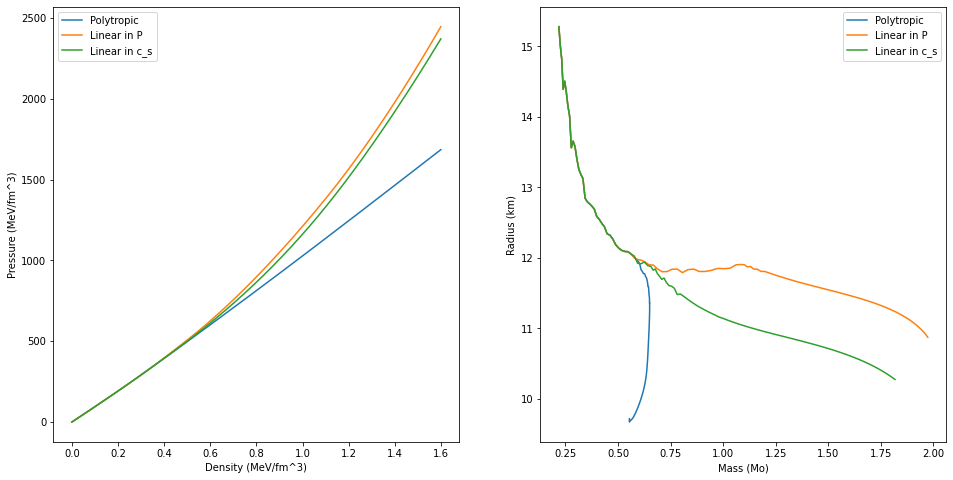

In [15]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(EOS_test_poly[:,0], EOS_test_poly[:,2], label='Polytropic')
ax[0].plot(EOS_test_lin[:,0], EOS_test_lin[:,2], label='Linear in P')
ax[0].plot(EOS_test_cs[:,0], EOS_test_cs[:,2], label='Linear in c_s')
ax[0].set_xlabel('Density (MeV/fm^3)')
ax[0].set_ylabel('Pressure (MeV/fm^3)')
ax[0].legend()

ax[1].plot(MRL_test_poly[:,0], MRL_test_poly[:,1], label='Polytropic')
ax[1].plot(MRL_test_lin[:,0], MRL_test_lin[:,1], label='Linear in P')
ax[1].plot(MRL_test_cs[:,0], MRL_test_cs[:,1], label='Linear in c_s')
ax[1].set_xlabel('Mass (Mo)')
ax[1].set_ylabel('Radius (km)')
ax[1].legend()

In [17]:
nsim = 10
shape_EOS = (EOS_test_cs.shape[0], EOS_test_cs.shape[1], nsim)
shape_MRL = (MRL_test_cs.shape[0],MRL_test_cs.shape[1], nsim)

In [18]:
many_EOS_poly = np.zeros(shape_EOS)
many_MRL_poly = np.zeros(shape_MRL)
for i in range(nsim):
    many_EOS_poly[:,:,i] = simulate_EOS(EOS_small, nsamp, ext_type='polytrop')
    many_MRL_poly[:,:,i] = real_TOVsolver.solve(many_EOS_poly[:,:,i], max_p)

C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


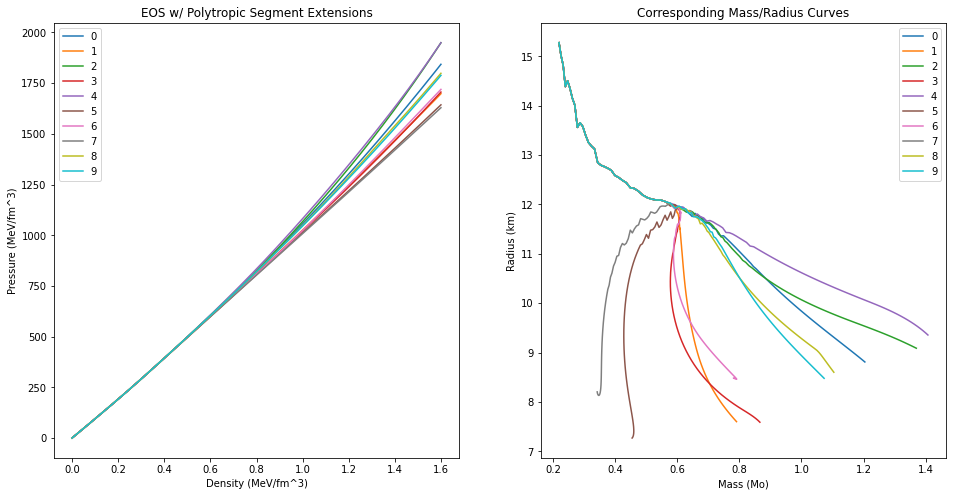

In [29]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

for i in range(nsim):
    ax[0].plot(many_EOS_poly[:,0,i], many_EOS_poly[:,2,i], label=i)
    ax[0].set_xlabel('Density (MeV/fm^3)')
    ax[0].set_ylabel('Pressure (MeV/fm^3)')
    ax[0].legend()
    ax[0].set_title('EOS w/ Polytropic Segment Extensions')

    ax[1].plot(many_MRL_poly[:,0,i], many_MRL_poly[:,1,i], label=i)
    ax[1].set_xlabel('Mass (Mo)')
    ax[1].set_ylabel('Radius (km)')
    ax[1].legend()
    ax[1].set_title("Corresponding Mass/Radius Curves")

In [20]:
many_EOS_cs = np.zeros(shape_EOS)
many_MRL_cs = np.zeros(shape_MRL)
for i in range(nsim):
    many_EOS_cs[:,:,i] = simulate_EOS(EOS_small, nsamp, ext_type='cs')
    many_MRL_cs[:,:,i] = real_TOVsolver.solve(many_EOS_cs[:,:,i], max_p)

C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


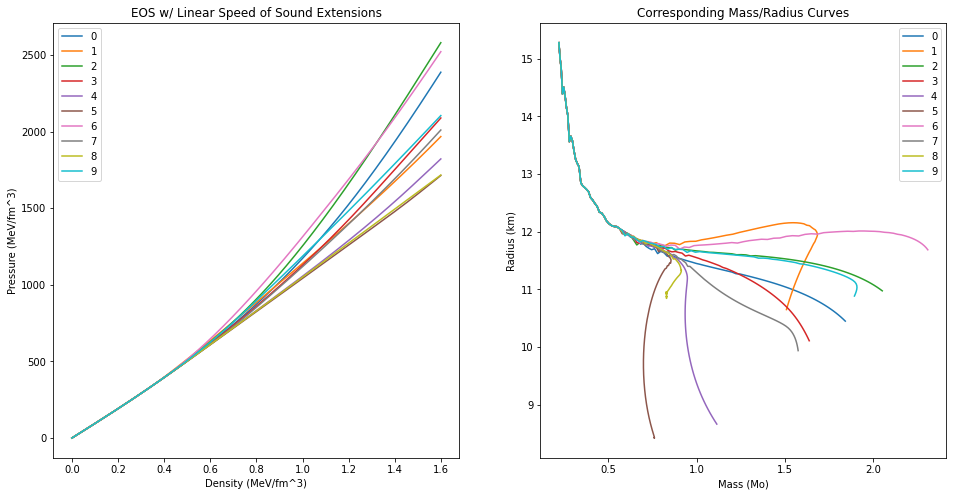

In [27]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

for i in range(nsim):
    ax[0].plot(many_EOS_cs[:,0,i], many_EOS_cs[:,2,i], label=i)
    ax[0].set_xlabel('Density (MeV/fm^3)')
    ax[0].set_ylabel('Pressure (MeV/fm^3)')
    ax[0].legend()
    ax[0].set_title('EOS w/ Linear Speed of Sound Extensions')

    ax[1].plot(many_MRL_cs[:,0,i], many_MRL_cs[:,1,i], label=i)
    ax[1].set_xlabel('Mass (Mo)')
    ax[1].set_ylabel('Radius (km)')
    ax[1].legend()
    ax[1].set_title("Corresponding Mass/Radius Curves")

In [24]:
many_EOS_lin = np.zeros(shape_EOS)
many_MRL_lin = np.zeros(shape_MRL)
for i in range(nsim):
    many_EOS_lin[:,:,i] = simulate_EOS(EOS_small, nsamp, ext_type='linear')
    many_MRL_lin[:,:,i] = real_TOVsolver.solve(many_EOS_lin[:,:,i], max_p)

C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


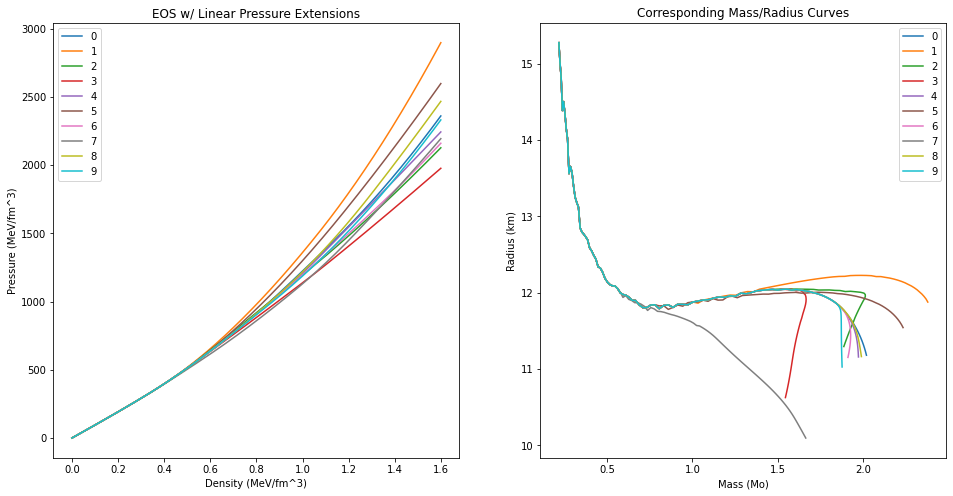

In [28]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

for i in range(nsim):
    ax[0].plot(many_EOS_lin[:,0,i], many_EOS_lin[:,2,i], label=i)
    ax[0].set_xlabel('Density (MeV/fm^3)')
    ax[0].set_ylabel('Pressure (MeV/fm^3)')
    ax[0].legend()
    ax[0].set_title('EOS w/ Linear Pressure Extensions')

    ax[1].plot(many_MRL_lin[:,0,i], many_MRL_lin[:,1,i], label=i)
    ax[1].set_xlabel('Mass (Mo)')
    ax[1].set_ylabel('Radius (km)')
    ax[1].legend()
    ax[1].set_title("Corresponding Mass/Radius Curves")